Code produced on google colab environment

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
## Import all packages needed

import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

Import train, validation arrays

In [0]:
X_train=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_train_200.npy')
y_train=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_train_200.npy')

In [0]:
X_train=X_train.reshape(6500,200,200,3)

In [0]:
X_val=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_val_200.npy')
y_val=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_val_200.npy')

In [0]:
X_val=X_val.reshape(1562,200,200,3)

In [0]:
## Load checkpoint and early stopping functions and other keras CNN modules

from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="/content/drive/My Drive/identify_pneumonia-master/model_2_weights/0.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', baseline=None, restore_best_weights=False)

from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
#Define the new loss function for counteract class imbalance

from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [0]:
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score

#Build CNN model 2

def create_model2(X_train, y_train, X_val, y_val, params):

  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3), data_format='channels_last'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))    

  model.add(Flatten())        

##Define the hyperparameter configuration to Talos package

  model.add(Dense(params['dense1'], activation='relu'))
  model.add(Dropout(params['drop1']))
  model.add(Dense(params['dense2'], activation='relu'))
  model.add(Dropout(params['drop2']))
  model.add(Dense(2 , activation='softmax'))

  from sklearn import metrics
  from keras import backend as K
  from tensorflow.keras.metrics import Recall
  from keras import optimizers

  ##Defined hyperparameters: loss function, otimizer, lr, decay, dense 1 units, dense 2 units, b size and dropout.

  w=np.array([0.25,4])
  w_loss=weighted_categorical_crossentropy(w)

  if params['otimizer']==adam:
      model.compile(loss=w_loss,
                      # here we add a regulizer normalization function from Talos
                      optimizer=params['otimizer'](lr=params['lr'], decay= params['decay'], beta_1=0.9, beta_2=0.999, amsgrad=False),
                      metrics=['acc'])
    
      print('yes')
  if params['otimizer']==sgd:
    model.compile(loss=w_loss,
                    # here we add a regulizer normalization function from Talos
                    optimizer=params['otimizer'](lr=params['lr'], decay= params['decay'], momentum=0.9, nesterov=True),
                    metrics=['acc'])
    print('yes2x')

  history = model.fit(X_train, y_train,
                        batch_size=params['b_size'],
                        epochs=80,
                        validation_data=(X_val, y_val),
                        )
  tf.get_default_graph()
    # finally we have to make sure that history object and model are returned
  return history, model

In [0]:
!pip install talos

     |████████████████████████████████| 26.6MB 1.9MB/s 
     |████████████████████████████████| 839kB 34.2MB/s 
  Created wheel for talos: filename=talos-0.6.3-cp36-none-any.whl size=49626 sha256=92e6fa6f518569c351600612bf7ed05703d2a98e2ebad5b4b325470f59c10c5a
  Stored in directory: /root/.cache/pip/wheels/bb/d7/6b/86fd8b1fc7cfbd2c54796412f86efb5fb6a3a5c734014f6a66
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=8b9e974d1d6dc753c18c97ef1caf7b4f95466ca71ac8360ad7bd36088dd1c699
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=15724d4f1718716497cea6a8bb2c8c86584e744cb281941fe66c19e475577fb2
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for chances: filename=chances-0.1.9-cp36-none-any.whl size=41609 sha256=958685c8c4fcc24d9d9cf923

In [0]:
import talos

In [0]:
##Set the hyperparameter values

from keras import optimizers

sgd = optimizers.SGD
adam=optimizers.Adam

p = {'drop1':[0.6], 'drop2':[0.5], 'lr':[0.001], 'decay':[1e-4], 'dense1':[256,512], 'dense2':[128,256],
     'otimizer':[adam], 'b_size':[64,128], 'w1':[[0.25,4]]}

In [0]:
#start the scan by Talos (10% of total combinations: 6 experiments)

t = talos.Scan(x=X_train,
            y=y_train,
            model=create_model2, 
            params=p,
            x_val=X_val, y_val=y_val,
            experiment_name='hyperoptimization_weightedMODEL2',
            fraction_limit=0.1,
            random_method='quantum',
            print_params=True)

  0%|          | 0/1 [00:00<?, ?it/s]

{'b_size': 64, 'decay': 0.0001, 'dense1': 256, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 100, 'lr': 0.001, 'otimizer': <class 'keras.optimizers.Adam'>, 'w1': [0.25, 4]}





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


yes
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6500 samples, validate on 1562 samples
Epoch 1/80





6500/6500 [==============================] - 42s 6ms/step - loss: 0.4900 - acc: 0.1643 - val_loss: 0.4696 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4815 - acc: 0.1569 - val_loss: 0.4690 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4813 - acc: 0.1569 - val_loss: 0.4699 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4749 - acc: 0.1569 - val_loss: 0.4601 - val_acc: 0.1524
Epoc

100%|██████████| 1/1 [39:51<00:00, 2391.11s/it]


In [0]:
t = talos.Scan(x=X_train,
            y=y_train,
            model=create_model3, 
            params=p,
            x_val=X_val, y_val=y_val,
            experiment_name='hyperoptimization_weightedMODEL2',
            fraction_limit=0.05,
            random_method='quantum',
            print_params=True)




  0%|          | 0/6 [00:00<?, ?it/s]

{'b_size': 64, 'decay': 0.0001, 'dense1': 256, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 32s 5ms/step - loss: 0.4862 - acc: 0.1657 - val_loss: 0.4689 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4739 - acc: 0.1569 - val_loss: 0.4689 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4744 - acc: 0.1569 - val_loss: 0.4694 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4738 - acc: 0.1569 - val_loss: 0.4688 - val_acc: 0.1524
Epoch 5/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4735 - acc: 0.1569 - val_loss: 0.4688 - val_acc: 0.1524
Epoch 6/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4742 - acc: 0.1




 17%|█▋        | 1/6 [40:42<3:23:32, 2442.54s/it]

{'b_size': 128, 'decay': 1e-06, 'dense1': 512, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 100, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4919 - acc: 0.1692 - val_loss: 0.4687 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4749 - acc: 0.1569 - val_loss: 0.4686 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4739 - acc: 0.1569 - val_loss: 0.4688 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4723 - acc: 0.1569 - val_loss: 0.4672 - val_acc: 0.1524
Epoch 5/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4729 - acc: 0.1569 - val_loss: 0.4655 - val_acc: 0.1524
Epoch 6/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4691 - acc: 0.




 33%|███▎      | 2/6 [1:19:46<2:40:51, 2413.00s/it]

{'b_size': 128, 'decay': 0.0001, 'dense1': 512, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.001, 'otimizer': <class 'keras.optimizers.Adam'>, 'w1': [0.25, 4]}
yes
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4922 - acc: 0.1623 - val_loss: 0.4732 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4801 - acc: 0.1569 - val_loss: 0.4632 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 29s 4ms/step - loss: 0.4507 - acc: 0.1895 - val_loss: 0.3889 - val_acc: 0.2420
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4121 - acc: 0.3217 - val_loss: 0.3856 - val_acc: 0.3073
Epoch 5/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.3960 - acc: 0.3975 - val_loss: 0.3729 - val_acc: 0.3387
Epoch 6/80
6500/6500 [==============================] - 29s 4ms/step - loss: 0.3927 - acc: 0.




 50%|█████     | 3/6 [1:58:49<1:59:36, 2392.10s/it]

{'b_size': 128, 'decay': 0.0001, 'dense1': 512, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4972 - acc: 0.1768 - val_loss: 0.4687 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4747 - acc: 0.1569 - val_loss: 0.4693 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4749 - acc: 0.1569 - val_loss: 0.4682 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4734 - acc: 0.1569 - val_loss: 0.4672 - val_acc: 0.1524
Epoch 5/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4723 - acc: 0.1569 - val_loss: 0.4647 - val_acc: 0.1524
Epoch 6/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4659 - acc: 0.




 67%|██████▋   | 4/6 [2:38:13<1:19:27, 2383.67s/it]

{'b_size': 128, 'decay': 0.0001, 'dense1': 512, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 100, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4914 - acc: 0.1760 - val_loss: 0.4688 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4738 - acc: 0.1569 - val_loss: 0.4710 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4746 - acc: 0.1569 - val_loss: 0.4680 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4728 - acc: 0.1569 - val_loss: 0.4667 - val_acc: 0.1524
Epoch 5/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4699 - acc: 0.1569 - val_loss: 0.4622 - val_acc: 0.1524
Epoch 6/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4645 - acc: 0




 83%|████████▎ | 5/6 [3:17:35<39:36, 2376.96s/it]  

{'b_size': 64, 'decay': 1e-06, 'dense1': 512, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.Adam'>, 'w1': [0.25, 4]}
yes
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 32s 5ms/step - loss: 3.3714 - acc: 0.1595 - val_loss: 3.4156 - val_acc: 0.1524
Epoch 2/80
6500/6500 [==============================] - 31s 5ms/step - loss: 3.3972 - acc: 0.1569 - val_loss: 3.4156 - val_acc: 0.1524
Epoch 3/80
6500/6500 [==============================] - 31s 5ms/step - loss: 3.3972 - acc: 0.1569 - val_loss: 3.4156 - val_acc: 0.1524
Epoch 4/80
6500/6500 [==============================] - 31s 5ms/step - loss: 3.3972 - acc: 0.1569 - val_loss: 3.4156 - val_acc: 0.1524
Epoch 5/80
6500/6500 [==============================] - 31s 5ms/step - loss: 3.3972 - acc: 0.1569 - val_loss: 3.4156 - val_acc: 0.1524
Epoch 6/80
6500/6500 [==============================] - 31s 5ms/step - loss: 3.3972 - acc: 0.156




100%|██████████| 6/6 [3:58:26<00:00, 2399.27s/it]




In [0]:
#Resume of experiments: training and validation accuracy/loss
# PS: experiment no. 4 were replaced by an individual experiment (option)

t.data

CHOOSE THE BEST MODEL 2

--Define and replace the hyperparameters values for each of the 6 experiments (manually) and re-train each configuration.

--Save the best weights: for the highest validation accuracy obtained before validation loss starts to increse.

In [0]:
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score

def weighted_pneumo_model():

  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3), data_format='channels_last'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))    

  model.add(Flatten())        


  model.add(Dense(256, activation='relu'))
  
  model.add(Dropout(0.6))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2 , activation='softmax'))

  from sklearn import metrics
  from keras import backend as K
  from tensorflow.keras.metrics import Recall
  from keras import optimizers

  w=np.array([0.25,4])
  w_loss=weighted_categorical_crossentropy(w)
  
  model.compile(loss=w_loss,
                    # here we add a regulizer normalization function from Talos
                    optimizer=optimizers.sgd(lr=0.01,decay=1e-06, momentum=0.9, nesterov=True),
                    metrics=['acc'])


  history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=150,
                        validation_data=(X_val, y_val),
                      callbacks=[earlystop]
                        )

  tf.get_default_graph()
    # finally we have to make sure that history object and model are returned
  return  model, history

MODEL 2 PERFORMANCE ON VALIDATION SET XP1'

In [0]:
#load model2 with the replaced hyperparameters values (with each experiment configuration)
model_2=weighted_pneumo_model()

In [0]:
#only get the model architecture and parameters
bestmodel=model_2[0]

In [0]:
##load the saved weights of each experiment ##load the saved weights of each experiment (IT IS IMPORTANT THAT "model_2" has the same configuration as the experiment in loading. Otherwise it will give errors in the weights)
bestmodel.load_weights('/content/drive/My Drive/identify_pneumonia-master/model_2_weights/0.hdf5')

In [0]:
#load the validation arrays and labels
X_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_val_200.npy')
y_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_val_200.npy')

In [0]:
##reshape if there is an error on input shape

X_test=X_test.reshape(500,200,200,3)

In [0]:
##Results on validation data

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
y_pred = bestmodel.predict(X_val)

thresholders=[]  
for x in range(len(y_pred)):
  if y_pred[x][1]>0.5:   #define threshold range (optional)
    thresholders.append(1)
  else:
    thresholders.append(0)

thr_pred=np.asarray(thresholders)

y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_val, axis=1)

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
plt.show()

FROM THE VALIDATION PREDICTION RESULTS ABOVE WE CHOOSE EXPERIMENT 1 AS BEST MODEL 2!!!

--Load best model weights for each experiment

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

In [0]:
##Plot the model behavior
history=model_2[0]

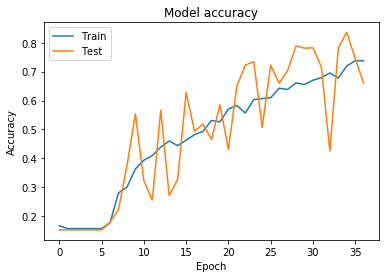

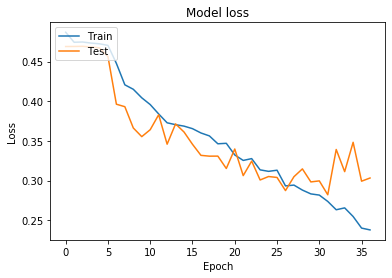

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()